In [1]:
import pymysql
import pandas as pd
import numpy as np
import re
import jieba

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

TENCENT_VECTOR_PATH = '/Users/huan/Desktop/weibo/word_vector/Tencent_AILab_ChineseEmbedding.txt'
MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 200

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

In [3]:
df = pd.read_sql_query('select name,tag from base_goods', conn)

In [4]:
def find_chinese(file):
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese = re.sub(pattern, '', file)
    return chinese

def replace_puncs(x):
    return re.sub(r'[^\w\s]','',x)

def remove_blanks(x):
    return re.sub(r'\s{2,}','',x)

def cut_text(x):
    return list(jieba.cut(x,cut_all=False))

def preprocess_texts(df):

    df['clean_name'] = df.name.apply(remove_blanks).apply(replace_puncs).apply(find_chinese).values
    df['cutted_text'] = df.clean_name.apply(cut_text).values
    df['texts'] = df.cutted_text.apply(lambda x:' '.join(x)).values
    df.loc[:,'sequence_length'] = df.cutted_text.apply(lambda x:len(x)).values
    df = df[(df.sequence_length >0) & (df.sequence_length <= MAX_SEQUENCE_LENGTH)]
    return df

In [5]:
df = preprocess_texts(df)

Building prefix dict from the default dictionary ...
I0712 12:56:03.605480 4681330112 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0712 12:56:03.607781 4681330112 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.635 seconds.
I0712 12:56:04.241930 4681330112 __init__.py:163] Loading model cost 0.635 seconds.
Prefix dict has been built succesfully.
I0712 12:56:04.243350 4681330112 __init__.py:164] Prefix dict has been built succesfully.


In [6]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df.texts)
num_words = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print('Number of word considered: {}'.format(num_words))
word2index = tokenizer.word_index

Number of word considered: 50000


In [7]:
sequences = tokenizer.texts_to_sequences(df.texts)

In [8]:
padded_sequences = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)

In [9]:
embeddings_index = dict()
with open(TENCENT_VECTOR_PATH,'r', encoding = 'utf-8') as f:
    next(f)
    for line in f:
        values = line.split(' ')
        word = values[0]
        if word in word2index:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, ind in word2index.items():
    if ind < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[ind] = embedding_vector

In [10]:
from keras.layers import Input,Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate,Flatten
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [17]:
nonnull_index = np.where((df.tag != '').values)[0]
features = padded_sequences[nonnull_index]
targets = pd.Categorical(df.iloc[nonnull_index,:]['tag'])
idx_to_cat = {idx:cat for idx, cat in enumerate(pd.Categorical(targets.categories))}
targets = targets.codes
K = max(idx_to_cat) + 1

In [36]:
embedding_layer = Embedding(num_words,
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(input_dim=num_words, output_dim=200, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix],trainable=False)(inputs)
l_conv01 = Conv1D(128, 3,activation='relu',padding='same')(embedded_sequences)
l_pool01 = MaxPooling1D(3)(l_conv01)
l_conv02 = Conv1D(128, 4,activation='relu',padding='same')(embedded_sequences)
l_pool02 = MaxPooling1D(5)(l_conv02)
l_conv03 = Conv1D(128, 5,activation='relu',padding='same')(embedded_sequences)
l_pool03 = MaxPooling1D(5)(l_conv03)
l_merge = concatenate([l_pool01,l_pool02,l_pool03],axis=1)

l_cov2 = Conv1D(128, 3, activation='relu',padding='same')(l_merge)
l_pool2 = MaxPooling1D(10)(l_cov2)
l_pool2 = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_pool2)
encoder = Model(inputs, l_dense)

encoded_vector = encoder(inputs)

preds = Dense(K, activation='softmax')(encoded_vector)

model=Model(inputs,preds)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [45]:
from keras.utils import plot_model

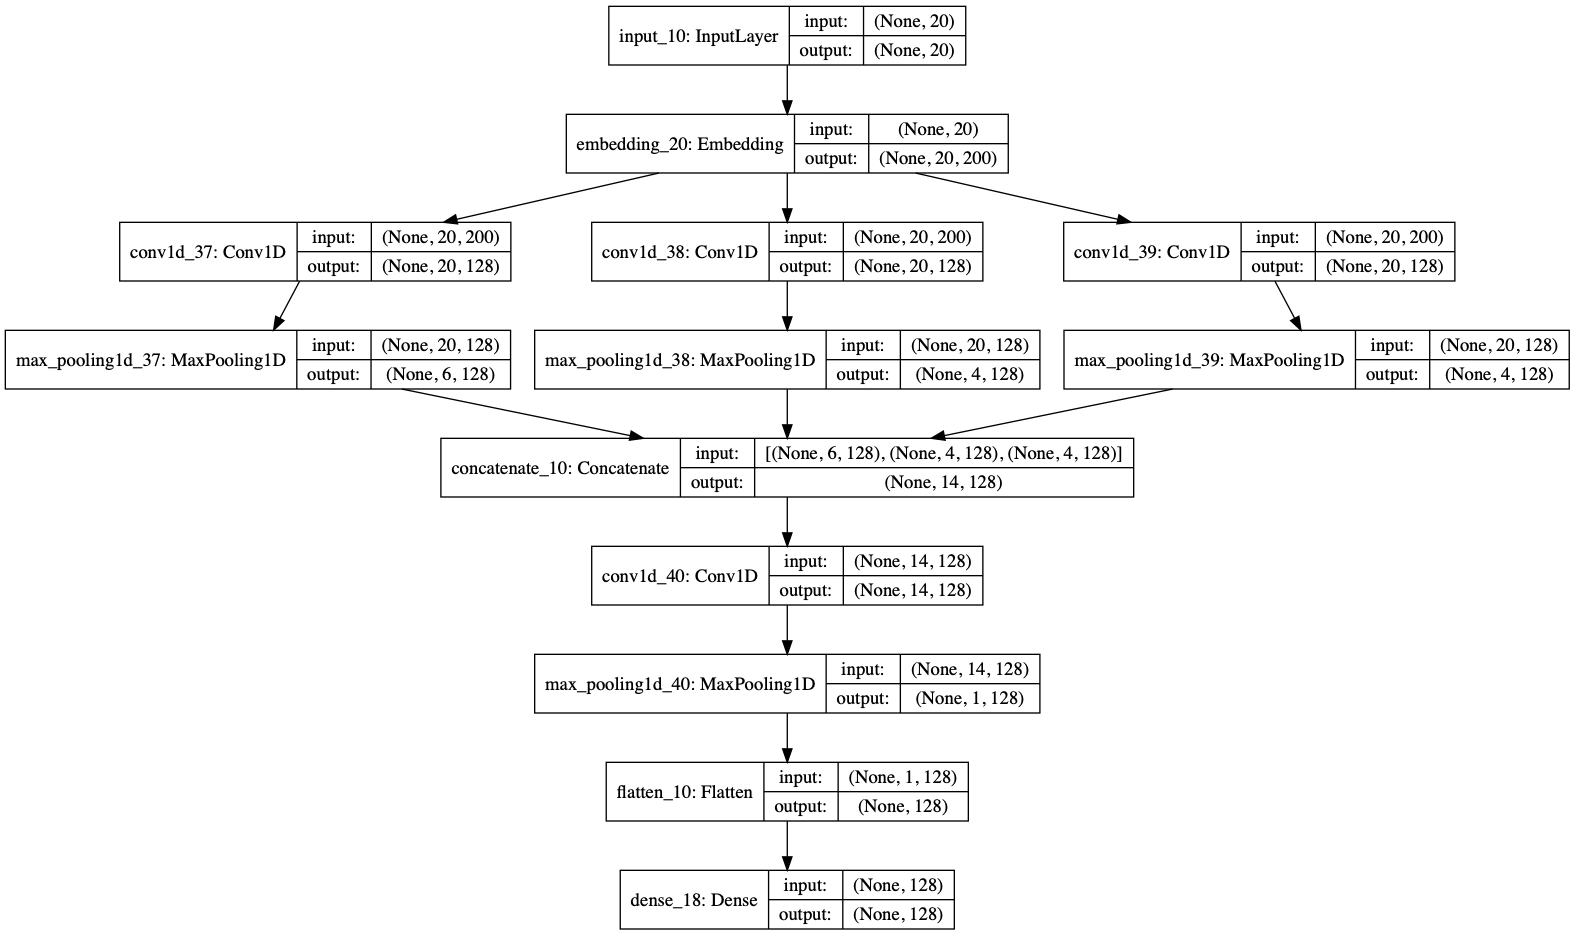

In [47]:
plot_model(encoder,show_shapes=True)

In [37]:
model.fit(features, targets,batch_size =128,epochs = 4,validation_split = 0.3)

Train on 87350 samples, validate on 37437 samples
Epoch 1/4
87350/87350 [==============================] - 26s 300us/step - loss: 0.5080 - accuracy: 0.8450 - val_loss: 0.3293 - val_accuracy: 0.9033
Epoch 2/4
87350/87350 [==============================] - 26s 293us/step - loss: 0.2395 - accuracy: 0.9289 - val_loss: 0.2781 - val_accuracy: 0.9191
Epoch 3/4
87350/87350 [==============================] - 26s 293us/step - loss: 0.1704 - accuracy: 0.9495 - val_loss: 0.2762 - val_accuracy: 0.9226
Epoch 4/4
87350/87350 [==============================] - 26s 298us/step - loss: 0.1243 - accuracy: 0.9620 - val_loss: 0.2894 - val_accuracy: 0.9208


In [38]:
padded_sequences = pad_sequences(tokenizer.texts_to_sequences(preprocess_texts(df[df.tag == '']).texts), maxlen = MAX_SEQUENCE_LENGTH)
preds = model.predict(padded_sequences).argmax(axis = 1)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [39]:
tmp = df[df.tag == '']

In [40]:
tmp['predictions'] = [idx_to_cat[p] for p in preds]

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
encoder.predict(padded_sequences).shape

(54584, 128)

In [41]:
tmp.head(100)

,name,tag,clean_name,cutted_text,texts,sequence_length,predictions
1,【橙子快跑】无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐600g,,橙子快跑无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐,"[橙子, 快, 跑, 无, 蔗糖, 全麦, 面包, 南瓜, 藜, 麦, 健康, 粗纤, 健身...",橙子 快 跑 无 蔗糖 全麦 面包 南瓜 藜 麦 健康 粗纤 健身 代 早餐,15,食品
3,东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器,,东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器,"[东菱, 早餐, 机, 多功能, 三合, 一家, 用, 三明治, 宿舍, 锅, 学生, 锅,...",东菱 早餐 机 多功能 三合 一家 用 三明治 宿舍 锅 学生 锅 电热 煮 锅 懒人 神器,17,百货
6,WRZ i7耳机原装正品适用苹果6s华为oppo小米vivo入耳式有线高音质,,耳机原装正品适用苹果华为小米入耳式有线高音质,"[耳机, 原装, 正品, 适用, 苹果, 华为, 小米, 入耳式, 有线, 高音质]",耳机 原装 正品 适用 苹果 华为 小米 入耳式 有线 高音质,10,手机
15,一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套,,一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套,"[一次性, 洗脸, 巾, 纯棉, 压缩, 毛巾, 旅行装, 浴巾, 女, 旅游, 酒店用品,...",一次性 洗脸 巾 纯棉 压缩 毛巾 旅行装 浴巾 女 旅游 酒店用品 便携 床单 枕套,14,百货
16,工装短裤女高腰夏宽松2019新款韩版显瘦bf风休闲潮ins五分裤外穿,,工装短裤女高腰夏宽松新款韩版显瘦风休闲潮五分裤外穿,"[工装, 短裤, 女高, 腰夏, 宽松, 新款, 韩版显, 瘦风, 休闲, 潮, 五分裤, 外穿]",工装 短裤 女高 腰夏 宽松 新款 韩版显 瘦风 休闲 潮 五分裤 外穿,12,女装
22,苹果x钢化膜iphone7/8plus手机iphonex/xr/8p防偷窥膜6防窥iphon...,,苹果钢化膜手机防偷窥膜防窥全屏覆盖防窥膜偷看,"[苹果, 钢化, 膜, 手机, 防, 偷窥, 膜, 防窥, 全屏, 覆盖, 防窥膜, 偷看]",苹果 钢化 膜 手机 防 偷窥 膜 防窥 全屏 覆盖 防窥膜 偷看,12,手机
26,韩纪深海水母沁润面膜女补水保湿滋润提亮肤色面膜贴收缩毛孔学生,,韩纪深海水母沁润面膜女补水保湿滋润提亮肤色面膜贴收缩毛孔学生,"[韩纪, 深海, 水母, 沁润, 面膜, 女, 补水, 保湿, 滋润, 提亮, 肤色, 面膜...",韩纪 深海 水母 沁润 面膜 女 补水 保湿 滋润 提亮 肤色 面膜 贴 收缩 毛孔 学生,16,护肤
28,跳绳健身减肥运动燃脂计数器成人专用儿童小学生中考负重专业绳子,,跳绳健身减肥运动燃脂计数器成人专用儿童小学生中考负重专业绳子,"[跳绳, 健身, 减肥, 运动, 燃脂, 计数器, 成人, 专用, 儿童, 小学生, 中考,...",跳绳 健身 减肥 运动 燃脂 计数器 成人 专用 儿童 小学生 中考 负重 专业 绳子,14,其他
29,霞飞口红女学生持久保湿滋润奶茶色小辣椒唇膏姨妈平价豆沙色包邮,,霞飞口红女学生持久保湿滋润奶茶色小辣椒唇膏姨妈平价豆沙色包邮,"[霞飞, 口红, 女, 学生, 持久, 保湿, 滋润, 奶茶, 色, 小辣椒, 唇膏, 姨妈...",霞飞 口红 女 学生 持久 保湿 滋润 奶茶 色 小辣椒 唇膏 姨妈 平价 豆沙 色 包邮,16,护肤
30,手机防水袋游泳潜水套触屏密封oppo苹果vivo华为通用外卖专用骑手,,手机防水袋游泳潜水套触屏密封苹果华为通用外卖专用骑手,"[手机, 防水, 袋, 游泳, 潜水, 套触, 屏, 密封, 苹果, 华为, 通用, 外卖,...",手机 防水 袋 游泳 潜水 套触 屏 密封 苹果 华为 通用 外卖 专用 骑手,14,手机


In [48]:
import pickle

In [68]:
model_config = {"EMBEDDING_DIM":EMBEDDING_DIM, 'num_words':num_words,'MAX_SEQUENCE_LENGTH':MAX_SEQUENCE_LENGTH,'K':K}

In [70]:
np.save('item_embedding/resources/embedding_matrix.npy',embedding_matrix)
pickle.dump(tokenizer,open('item_embedding/resources/tokenizer.pkl','wb'))
model.save_weights('item_embedding/resources/item_embedding_model.h5')
encoder.save_weights('item_embedding/resources/item_encoding.h5')
model.save('item_embedding/resources/item_type_prediction_model.h5')
encoder.save('item_embedding/resources/encoder_model.h5')
pickle.dump(model_config, open('item_embedding/resources/model_config.pkl','wb'))
pickle.dump(idx_to_cat, open('item_embedding/resources/idx_to_cat.pkl','wb'))